# ASHRAE - Great Energy Predictor III

# 0. General Project / Past Competition Information


- Aim: (Accurately) Predicting energy consumption of commercial buildings. (Calculate djusted baseline energy while measured energy and weather conditions are known.)
- Dataset: 20 million rows, covering three years of hourly data from 2,380 meters ({0: electricity, 1: chilledwater, 2: steam, 3: hotwater}) across 1,448 commercial buildings

Kaggle Competition link: https://www.kaggle.com/competitions/ashrae-energy-prediction/data 

*Possible features*: (to be updated;)
- meter_reading
- air_temperature
- dew_temperature
- wind_speed
- precip_depth_1_hr
- sea_level_pressure
- square_feet
- primary_use
- meter
- energy_intensity
+ hour +
+ weekday +
+ season +
+ HDH +
+ CDH +
+ wind_chill_effect +
+ building_age ? +
+ is_peak




*Model Selection*:
- Gradient Boosting Machines (GBMs) - esp. LightGBM (the most due to effc.)
- Ensemble methods (XGBoost)
- TSML? time-series
- NN, CatBoost

- Cross-validation (model tuning, time-based split - train on 2016, calidate on 2017)


*Evaluation Metric*:
Root Mean Squared Logarithmic Error (RMSLE):

$\sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log(1 + \hat{y}_i) - \log(1 + y_i) \right)^2}$

### Issues & Questions
- Data size is big, not easy to process each time. Sampling?
- is there a way to cache data and not have to load it from scratch each time? should we save the random sample I selected or not?
- Should I fillna() the missing data with median etc.? - air_temperature, cloud_coverage? or dropna()?



### Ideas / Solutions:
Clarence:
- fraction by 1% or 0.5%
- aggregate data (not hourly but daily sum (for short-term), monthly sum (for longer-term) etc.) -> loss of time-series data (HVAC load may differ in a day)
- go with one building and scale up later -> may not generalize later? (instead, start with single site (same climate zone) and meter?)

Feature Engineering
- DROP COLS: floor_count remove, year_built remove it (you can sample out non missing, and then use that to subsample? but in practice). for ai. cloud_coverage drop
- IMPUTATION: precipitation -> do some imputation, explore and figure out the trend (is it dependent on other features? - linregression?) - linreg or median would work. sea_level_pres (meand/meadian would be fine) and wind direction (circular mean imputation or use sine/cosine transformation)
- DROP ROWS: for dew and air temp, drop the rows only if less than 5%

- remove energy_intensity from the model in general
- monthly aggregation?

remove zeros??? - why? explanation -> operational hours, due to sensor faults / missing values
- R2 - why that low?


### Observations:
- Scatter plot (log-temp): Electricity usage depends on more than just temperature—it’s influenced by HVAC, occupancy, and operational patterns.
-  low R² (~0.14) suggests a weak linear relationship. This is expected because energy consumption is influenced by non-linear factors like HVAC control strategies, occupancy, and weather variability. -> Try tree-based models (XGBoost, Random Forest) might improve R².
- Instead of blindly dropping year_built, you could derive building_age (2025 - year_built).
For cloud_coverage, check if it correlates with energy usage before removing it.
wind_direction is cyclical (0° and 360° are the same). You might transform it into sin(wind_direction) and cos(wind_direction).
- Train separate models for different meter types. Electricity (meter=0) behaves differently from chilled water (meter=1).
- Many outliers in the meter_reading. Log transformation is necessary!



# 1. Libraries & Data Set-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

## Merged dataset

In [2]:
# train = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/train.csv')
# building_metadata = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/building_metadata.csv')
# weather_train = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/weather_train.csv')

# test = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/test.csv')
# weather_test = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/weather_test.csv')

In [3]:
# print("-----------\nTrain Data:")
# display(train.head())
# print(train.info())
# print(f'Size of train data: {train.shape}')
# print("-----------\nBuilding Metadata:")
# display(building_metadata.head())
# print(building_metadata.info())
# print(f'Size of building_metadata data: {building_metadata.shape}')
# print("-----------\nWeather Train Data:")
# display(weather_train.head())
# print(weather_train.info())
# print(f'Size of weather_train data: {weather_train.shape}')

# '''
# Size of train_df data (20216100, 4)
# Size of weather_train_df data (139773, 9)
# Size of weather_test_df data (277243, 9)
# Size of building_meta_df data (1449, 6)
# '''

### Merging train + building_metadata + weather_train -> **'train_merged'** (via 'building_id' and 'site_id')

In [4]:
# import os
# cache_file = 'train_merged_cache.csv'

# if os.path.exists(cache_file):
#     train_merged = pd.read_csv(cache_file)
# else:
#     train_merged = pd.merge(train, building_metadata, on='building_id', how='left')
#     train_merged = pd.merge(train_merged, weather_train, on=['site_id', 'timestamp'], how='left')
#     train_merged.to_csv(cache_file, index=False)

# # display(train_merged.head()) # train + building_metadata + weather_train 

### Checking missing data (train_merged)

In [5]:
# missing_values = train_merged.isnull().sum()
# print("Missing values in each column:")
# print(missing_values[missing_values > 0])

# total = train_merged.isnull().sum().sort_values(ascending = False)
# percent = (train_merged.isnull().sum()/train_merged.isnull().count()*100).sort_values(ascending = False)
# missing__train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent (%)'])
# missing__train_data['Percent (%)'] = missing__train_data['Percent (%)'].map('{:.2f}'.format)
# display(missing__train_data)

## Sampling (For faster processing)

In [6]:
import random
# for i in range(10):
#     sample = train_merged.sample(frac=0.05, random_state=i)
#     sample.to_csv(f'train_sample_{i}.csv', index=False)

random_sample_index = random.randint(0, 9)
train_sample = pd.read_csv(f'train_sample_{random_sample_index}.csv')
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010805 entries, 0 to 1010804
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   building_id         1010805 non-null  int64  
 1   meter               1010805 non-null  int64  
 2   timestamp           1010805 non-null  object 
 3   meter_reading       1010805 non-null  float64
 4   site_id             1010805 non-null  int64  
 5   primary_use         1010805 non-null  object 
 6   square_feet         1010805 non-null  int64  
 7   year_built          405040 non-null   float64
 8   floor_count         175453 non-null   float64
 9   air_temperature     1006006 non-null  float64
 10  cloud_coverage      569021 non-null   float64
 11  dew_temperature     1005828 non-null  float64
 12  precip_depth_1_hr   823189 non-null   float64
 13  sea_level_pressure  949412 non-null   float64
 14  wind_direction      938388 non-null   float64
 15  wind_speed     

## Pre-processing

Visualizing missing values (heatmap):

In [7]:
# plt.figure(figsize=(10, 6))
# sns.heatmap(train_sample.isnull(), cbar=False, yticklabels=False)
# plt.title("Missing Values in Sampled Data (frac=0.05)")
# plt.show()

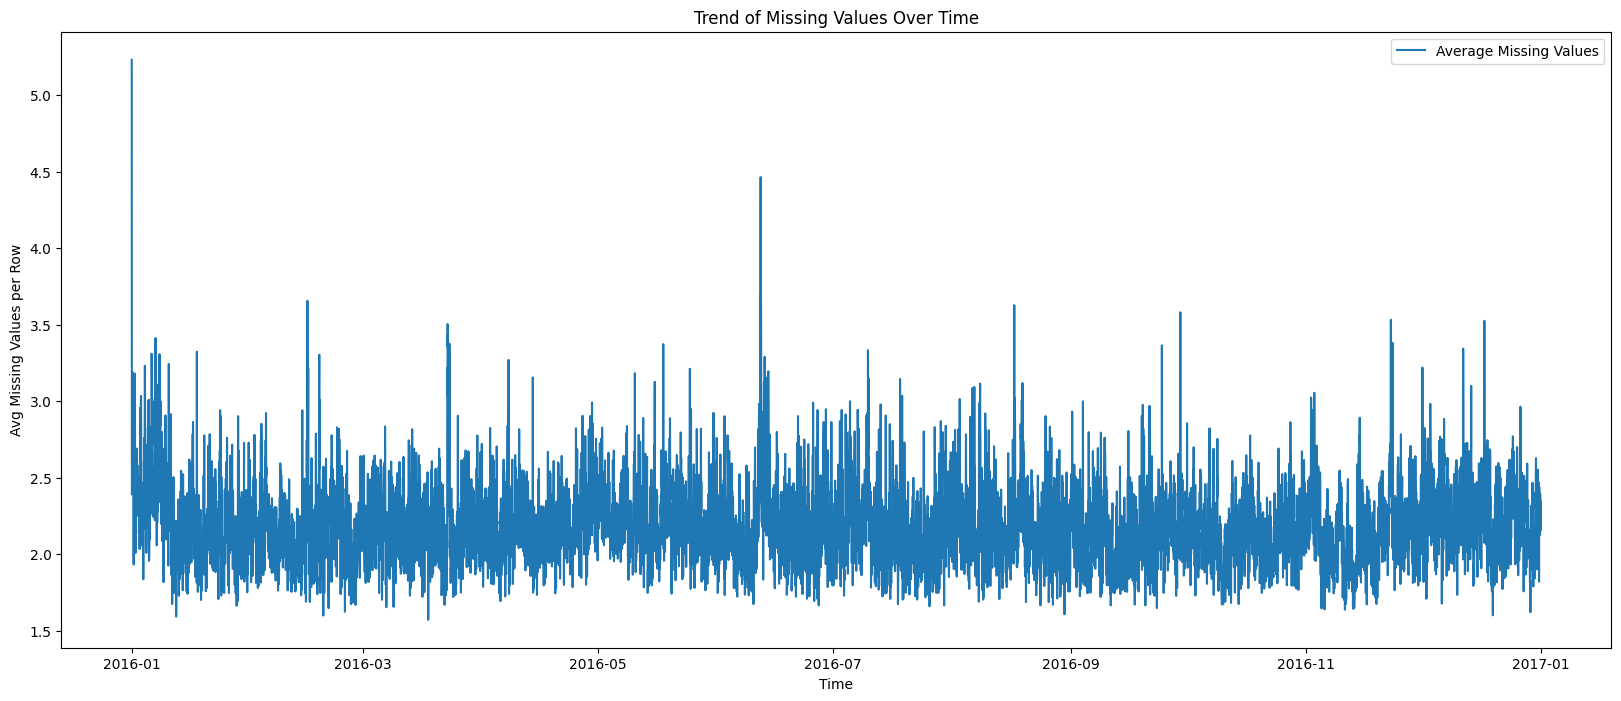

In [8]:
train_sample['timestamp'] = pd.to_datetime(train_sample['timestamp'])
train_sample['missing_values'] = train_sample.isnull().sum(axis=1)
missing_over_time = train_sample.groupby('timestamp')['missing_values'].mean()

plt.figure(figsize=(20, 8))
plt.plot(missing_over_time, label='Average Missing Values')
plt.xlabel('Time')
plt.ylabel('Avg Missing Values per Row')
plt.title('Trend of Missing Values Over Time')
plt.legend()
plt.show()

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_49899/4243165697.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_use = train_sample.groupby('primary_use').apply(lambda x: x.isnull().mean() * 100)


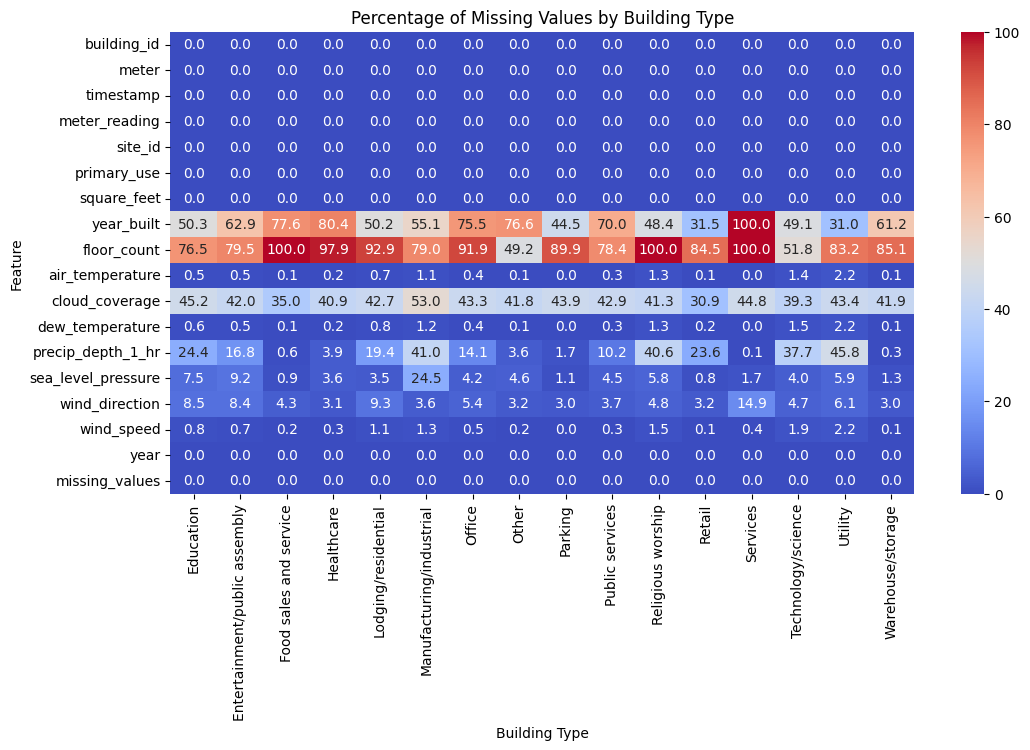

In [9]:
missing_by_use = train_sample.groupby('primary_use').apply(lambda x: x.isnull().mean() * 100)
plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_use.T, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Percentage of Missing Values by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Feature')
plt.xticks(rotation=90)
plt.show()

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_49899/173180020.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_meter = train_sample.groupby('meter').apply(lambda x: x.isnull().mean() * 100)


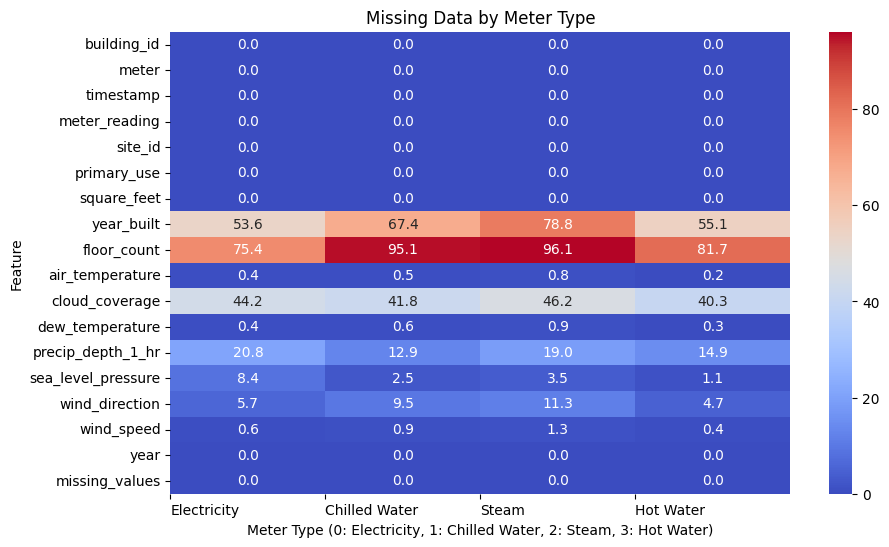

In [10]:
missing_by_meter = train_sample.groupby('meter').apply(lambda x: x.isnull().mean() * 100)

plt.figure(figsize=(10, 6))
sns.heatmap(missing_by_meter.T, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Missing Data by Meter Type')
plt.xlabel('Meter Type (0: Electricity, 1: Chilled Water, 2: Steam, 3: Hot Water)')
plt.ylabel('Feature')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Electricity', 'Chilled Water', 'Steam', 'Hot Water'], ha='left')
plt.show()

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_49899/386703477.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_site = train_sample.groupby('site_id').apply(lambda x: x.isnull().mean() * 100)


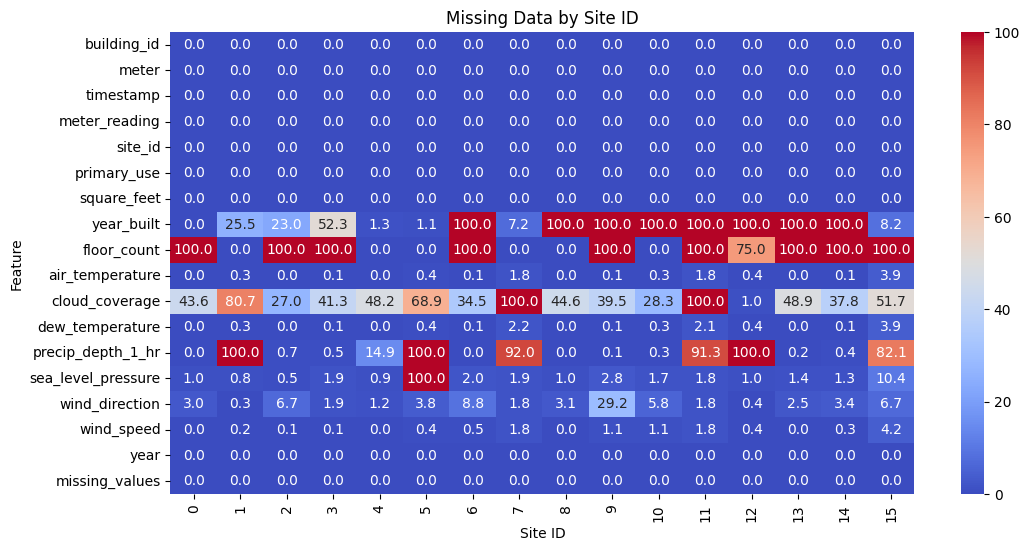

In [11]:
missing_by_site = train_sample.groupby('site_id').apply(lambda x: x.isnull().mean() * 100)

plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_site.T, cmap="coolwarm", annot=True, fmt=".1f")
plt.title('Missing Data by Site ID')
plt.xlabel('Site ID')
plt.ylabel('Feature')
plt.xticks(rotation=90)
plt.show()

In [12]:
train_sample.drop(columns=['floor_count','cloud_coverage'], inplace=True)
train_sample.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,missing_values
0,1312,3,2016-05-31 15:00:00,51.7833,14,Lodging/residential,75000,NaN,26.7,17.2,0.0,1013.9,30.0,5.1,2016,3
1,799,1,2016-04-26 22:00:00,0.0000,7,Education,527431,1976.0,10.1,-11.8,NaN,1010.7,330.0,5.1,2016,2
2,39,0,2016-08-22 22:00:00,317.0490,0,Office,64619,1969.0,35.6,20.0,0.0,1017.7,0.0,0.0,2016,1
3,5,0,2016-12-19 08:00:00,17.0640,0,Education,8000,2000.0,22.2,21.1,0.0,1025.0,0.0,0.0,2016,2
4,979,1,2016-11-12 13:00:00,156.8510,9,Entertainment/public assembly,52357,NaN,13.9,13.3,0.0,1023.9,300.0,1.5,2016,2


In [59]:
# impute missing values with median
train_sample['precip_depth_1_hr'].fillna(train_sample['precip_depth_1_hr'].median(), inplace=True)
train_sample['sea_level_pressure'].fillna(train_sample['sea_level_pressure'].median(), inplace=True)
train_sample['wind_direction'].fillna(train_sample['wind_direction'].median(), inplace=True)
train_sample['year_built'].fillna(train_sample['year_built'].median(), inplace=True)

train_sample['log_meter_reading'] = np.log1p(train_sample['meter_reading'])

train_sample.dropna(subset=['timestamp', 'wind_speed', 'air_temperature', 'dew_temperature'], inplace=True)

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_49899/4270033200.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_sample['precip_depth_1_hr'].fillna(train_sample['precip_depth_1_hr'].median(), inplace=True)
/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_49899/4270033200.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the inter

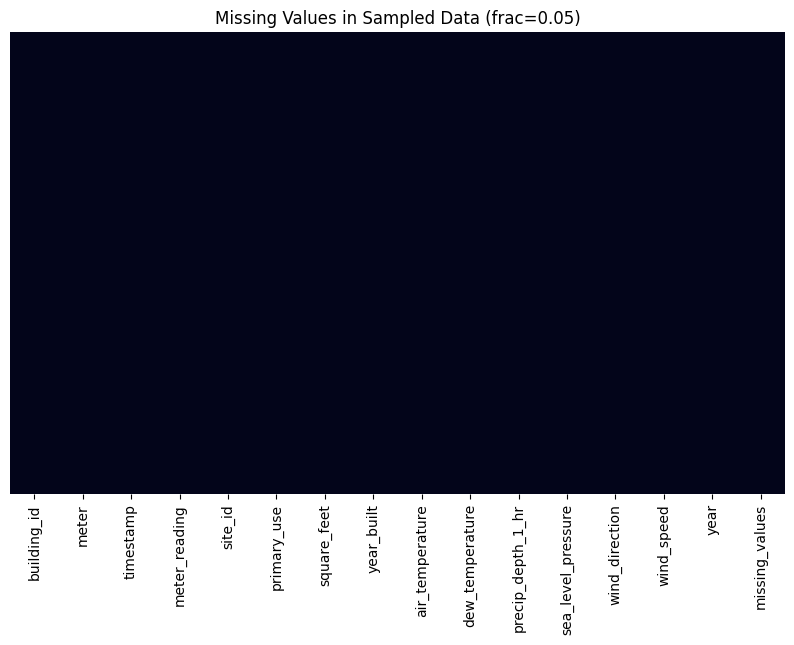

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_sample.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values in Sampled Data (frac=0.05)")
plt.show()

In [15]:
# complete_buildings = train_merged.dropna()
# display(complete_buildings.head())
# print(f'Number of buildings with all features filled: {len(complete_buildings)}')

# or

# train_sample['air_temperature'].fillna(train_sample['air_temperature'].median(), inplace=True)
# train_sample['hour'] = pd.to_datetime(train_sample['timestamp']).dt.hour
# train_sample['day_of_week'] = pd.to_datetime(train_sample['timestamp']).dt.dayofweek


# or more generally:
# fillna() for numerical columns
# num_cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
#             'sea_level_pressure', 'wind_direction', 'wind_speed', 'year_built']

# for col in num_cols:
#     train_sample[col].fillna(train_sample[col].median(), inplace=True)

# # dropna() floor_count (Too many missing values)
# train_sample.drop(columns=['floor_count'], inplace=True)

Check the entries where a feature is missing:

In [16]:
# cols_air_temp_missing = train_sample[train_sample['air_temperature'].isnull()]
# cols_air_temp_missing = cols_air_temp_missing.sort_values(by='building_id', ascending=False)
# cols_air_temp_missing

In [17]:
# # outlier detection
# factor = 1.5
# Q1 = train_sample['log_meter_reading'].quantile(0.25)
# Q3 = train_sample['log_meter_reading'].quantile(0.75)
# IQR = Q3 - Q1 # interquartile range 0.25-0.75
# lower_bound = Q1 - factor * IQR
# upper_bound = Q3 + factor * IQR
# train_sample = train_sample[(train_sample['log_meter_reading'] >= lower_bound) &
#                             (train_sample['log_meter_reading'] <= upper_bound)]

Segmentation by Meter Type:


In [18]:
electric_data = train_sample[train_sample['meter'] == 0]
chilled_water_data = train_sample[train_sample['meter'] == 1]
steam_data = train_sample[train_sample['meter'] == 2]
hotwater_data = train_sample[train_sample['meter'] == 3]

Building monthly meter dataset

In [19]:
# train_merged['timestamp'] = pd.to_datetime(train_merged['timestamp'])
# train_merged['year'] = train_merged['timestamp'].dt.year
# train_merged['month'] = train_merged['timestamp'].dt.month

# monthly_meter_aggregation = train_merged.groupby(['building_id', 'year', 'month'])['meter_reading'].sum().reset_index()

# monthly_meter_aggregation = pd.merge(monthly_meter_aggregation, building_metadata[['building_id', 'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count']], on='building_id', how='left')
# display(monthly_meter_aggregation.head())

### Feature Engineering & Selection

In [60]:
thresh_temp = 18 # outside air_temp
train_sample['HDH'] = train_sample['air_temperature'].apply(lambda x: max(thresh_temp - x, 0)) # heating degree hours
train_sample['CDH'] = train_sample['air_temperature'].apply(lambda x: max(x - thresh_temp, 0)) # cooling degree days

train_sample['wind_chill_effect'] = train_sample['wind_speed'] * (thresh_temp - train_sample['air_temperature']) # + -> heat loss, - -> can work as natural cooling

train_sample['hour'] = pd.to_datetime(train_sample['timestamp']).dt.hour
train_sample['day'] = pd.to_datetime(train_sample['timestamp']).dt.day
train_sample['weekday'] = pd.to_datetime(train_sample['timestamp']).dt.weekday # 1,2,3,4,5,6,7
train_sample['month'] = pd.to_datetime(train_sample['timestamp']).dt.month
train_sample['year'] = pd.to_datetime(train_sample['timestamp']).dt.year

# train_sample['is_peak'] = train_sample['hour'].apply(lambda x: 1 if 7 <= x <= 19 else 0)
# train_sample['is_night'] = train_sample['hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

train_sample['building_age'] = 2024 - train_sample['year_built']


train_sample.sort_values(by='building_id', inplace=True)
train_sample

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,dew_temperature,...,missing_values,HDH,CDH,wind_chill_effect,hour,day,weekday,month,building_age,log_meter_reading
558283,0,0,2016-06-09 18:00:00,242.309,0,Education,7432,2008.0,30.6,22.8,...,1,0.0,12.6,-78.12,18,9,3,6,16.0,5.494332
669886,0,0,2016-01-13 14:00:00,0.000,0,Education,7432,2008.0,10.6,0.6,...,2,7.4,0.0,30.34,14,13,2,1,16.0,0.000000
192536,0,0,2016-05-30 05:00:00,178.148,0,Education,7432,2008.0,22.8,21.7,...,2,0.0,4.8,-7.20,5,30,0,5,16.0,5.188212
61464,0,0,2016-04-14 22:00:00,0.000,0,Education,7432,2008.0,26.7,18.9,...,2,0.0,8.7,-53.94,22,14,3,4,16.0,0.000000
421707,0,0,2016-03-29 21:00:00,0.000,0,Education,7432,2008.0,19.4,16.7,...,2,0.0,1.4,-7.98,21,29,1,3,16.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276888,1448,0,2016-01-11 18:00:00,5.150,15,Office,92271,2001.0,-6.1,-13.3,...,4,24.1,0.0,161.47,18,11,0,1,23.0,1.816452
776204,1448,0,2016-10-23 21:00:00,2.725,15,Office,92271,2001.0,10.6,5.0,...,3,7.4,0.0,22.94,21,23,6,10,23.0,1.315067
2836,1448,0,2016-02-03 23:00:00,2.275,15,Office,92271,2001.0,10.6,8.3,...,3,7.4,0.0,22.94,23,3,2,2,23.0,1.186318
29297,1448,0,2016-07-23 06:00:00,3.450,15,Office,92271,2001.0,22.2,17.8,...,2,0.0,4.2,-17.22,6,23,5,7,23.0,1.492904


# 2. Initial EDA (assg#2)

Set graphical standards!

In [77]:
# plt.style.use('ggplot')
# color = 'darkblue'
# sns.set_theme(style="whitegrid", palette="muted")

sns.despine(left=True, bottom=True)
sns.set_theme(style="whitegrid", 
              rc={"axes.labelsize": 14, "axes.titlesize": 16, 
                  "xtick.labelsize": 12, "ytick.labelsize": 12, 
                  "axes.titleweight": "regular", "axes.labelweight": "regular", 
                  "grid.linestyle": "--", "grid.alpha": 0.5, 
                  "font.family": "sans-serif", "font.weight": "regular"})

# Custom color palette to match ggplot2
custom_palette = ["#5EB296", "#4E9EBA", "#F29239", "#C2CE46", "#FF7A7F", "#4D4D4D"]
sns.set_palette(custom_palette)

<Figure size 640x480 with 0 Axes>

Lowest Point - Hour: 4.0, Median Reading: 59.7892
Highest Point - Hour: 13.0, Median Reading: 97.0


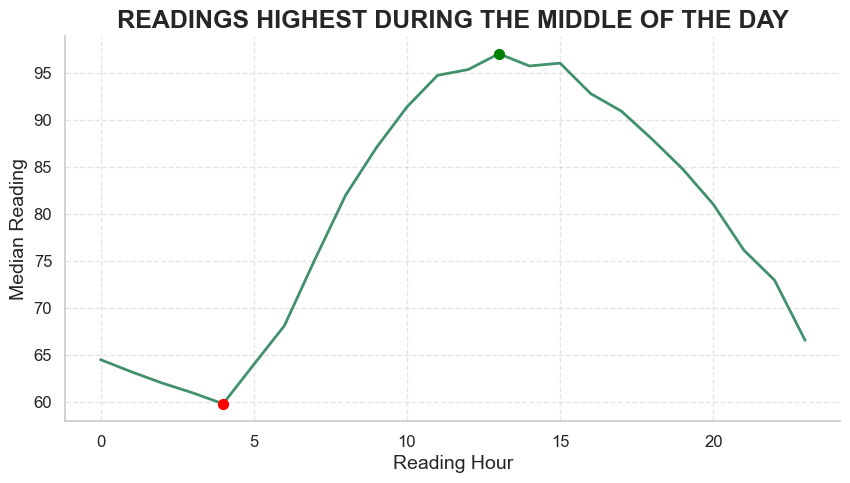

In [78]:
hourly_median = train_sample.groupby('hour')['meter_reading'].median().reset_index()

# Set ggplot style aesthetics
plt.figure(figsize=(10, 5))

# Plot the line graph
sns.lineplot(data=hourly_median, x='hour', y='meter_reading', color='#40916C', linewidth=2)

plt.title("READINGS HIGHEST DURING THE MIDDLE OF THE DAY", fontsize=18, weight='bold', loc='center')
plt.xlabel("Reading Hour", fontsize=14)
plt.ylabel("Median Reading", fontsize=14)

lowest_point = hourly_median.loc[hourly_median['meter_reading'].idxmin()]
highest_point = hourly_median.loc[hourly_median['meter_reading'].idxmax()]
print(f"Lowest Point - Hour: {lowest_point['hour']}, Median Reading: {lowest_point['meter_reading']}")
print(f"Highest Point - Hour: {highest_point['hour']}, Median Reading: {highest_point['meter_reading']}")

plt.scatter(lowest_point['hour'], lowest_point['meter_reading'], color='red', s=50, zorder=5)
plt.scatter(highest_point['hour'], highest_point['meter_reading'], color='green', s=50, zorder=5)

sns.despine()
plt.show()

Text(0, 0.5, '')

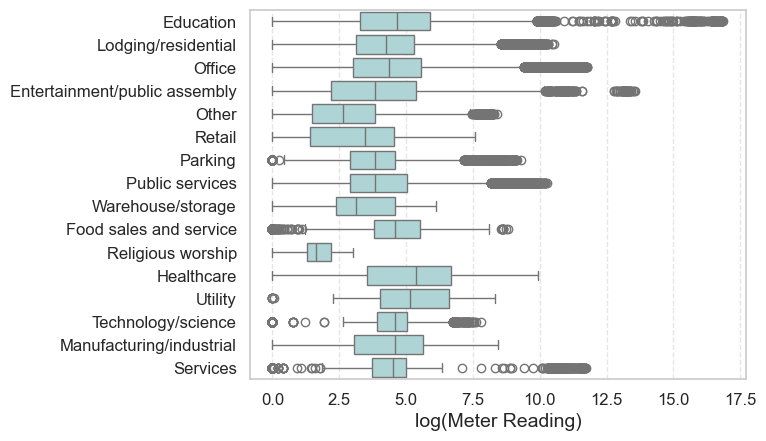

In [61]:
sns.boxplot(data=train_sample, x="log_meter_reading", y="primary_use", color="#a8dadc")
plt.xlabel("log(Meter Reading)", fontsize=14)
plt.ylabel("")

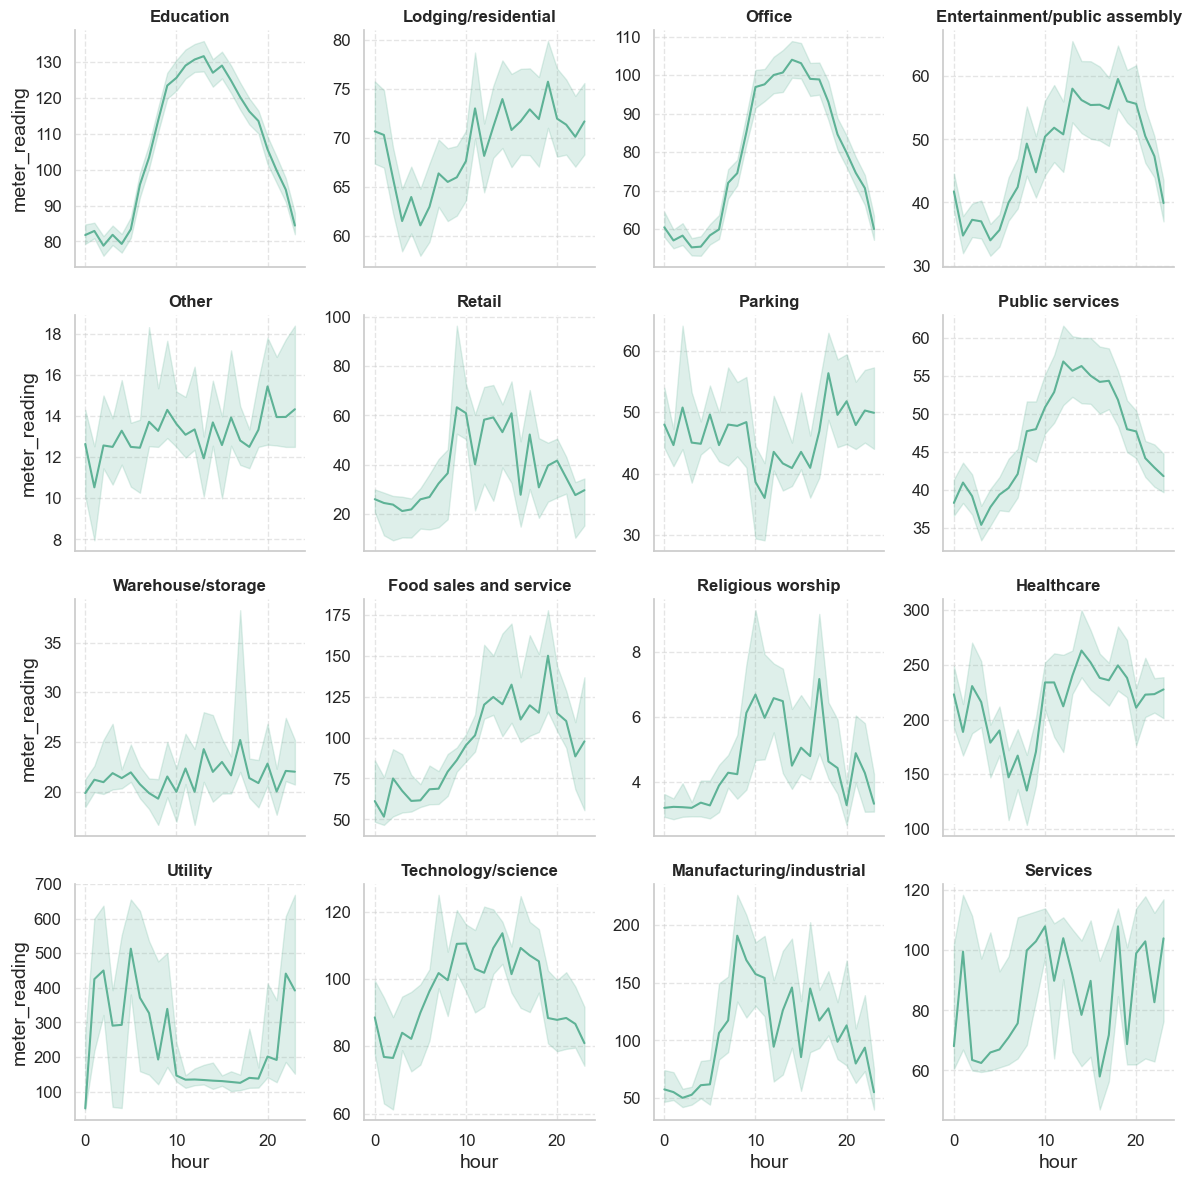

In [62]:
g = sns.FacetGrid(train_sample, col="primary_use", col_wrap=4, height=3, sharey=False)
g.map_dataframe(sns.lineplot, x="hour", y="meter_reading", estimator="median")

g.set_titles(col_template="{col_name}", size=12, fontweight="bold")
plt.show()

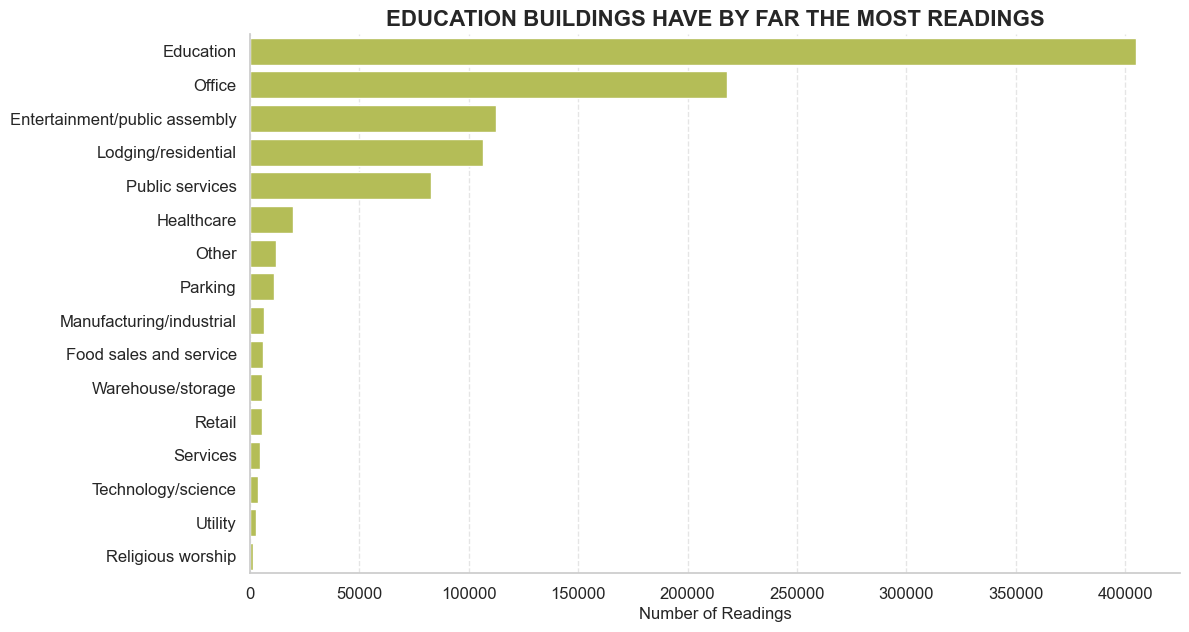

In [ ]:
building_counts = train_sample["primary_use"].value_counts().reset_index()
building_counts.columns = ["Building Type", "Number of Readings"]
building_counts = building_counts.sort_values(by="Number of Readings", ascending=False)

plt.figure(figsize=(12, 7))
ax = sns.barplot(y="Building Type", x="Number of Readings", data=building_counts, color="#C2CE46")

sns.despine(left=True, bottom=True)
plt.title("EDUCATION BUILDINGS HAVE BY FAR THE MOST READINGS", fontsize=16, fontweight="bold")
plt.xlabel("Number of Readings", fontsize=12)
plt.ylabel("")
plt.show()


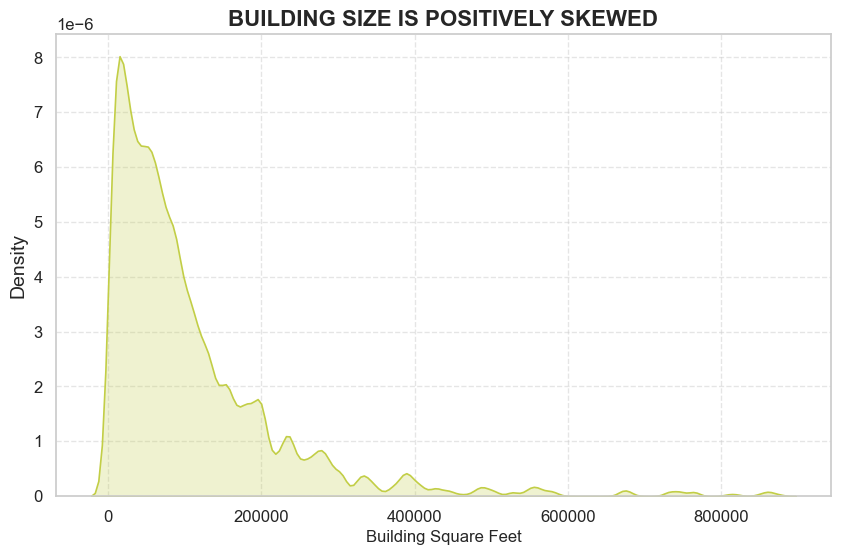

In [76]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(train_sample["square_feet"], fill=True, color="#C2CE46", linewidth=1.2)
plt.title("BUILDING SIZE IS POSITIVELY SKEWED", fontsize=16, fontweight="bold")
plt.xlabel("Building Square Feet", fontsize=12)
plt.ylabel("Density")
plt.show()

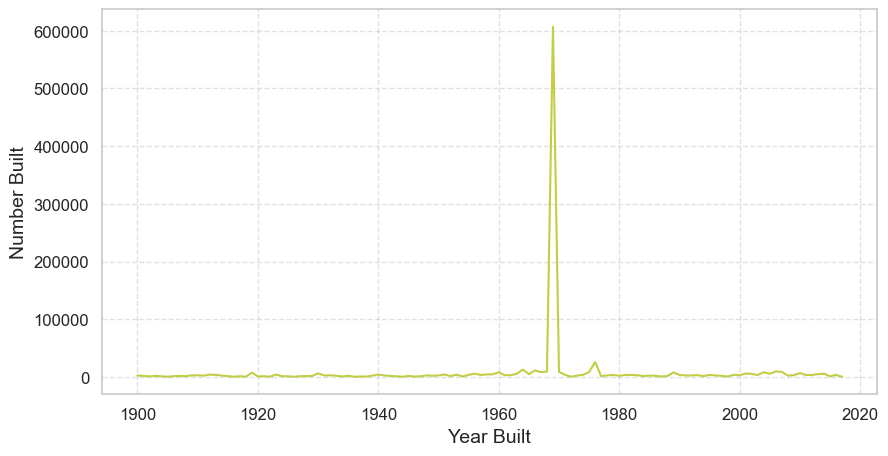

In [70]:
year_built_counts = train_sample['year_built'].dropna().astype(int).value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x=year_built_counts.index, y=year_built_counts.values, color="#C2CE46")

plt.xlabel("Year Built", fontsize=14)
plt.ylabel("Number Built", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

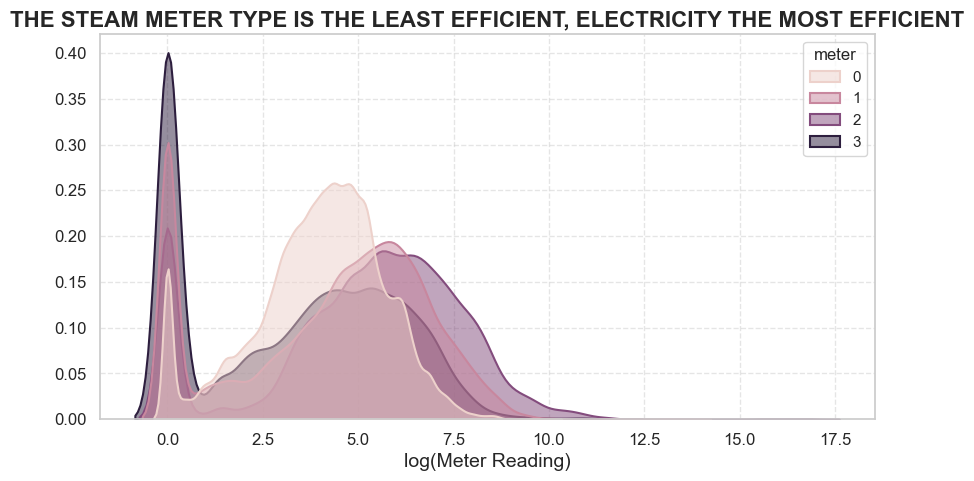

In [ ]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=train_sample, x=np.log1p(train_sample['meter_reading']), hue="meter", fill=True, common_norm=False, alpha=0.5, linewidth=1.5)

plt.title("THE STEAM METER TYPE IS THE LEAST EFFICIENT, ELECTRICITY THE MOST EFFICIENT", fontsize=16, fontweight='bold', loc='center')
plt.xlabel("log(Meter Reading)")
plt.ylabel("")
plt.show()

1. Histogram - log_meter_reading distribution

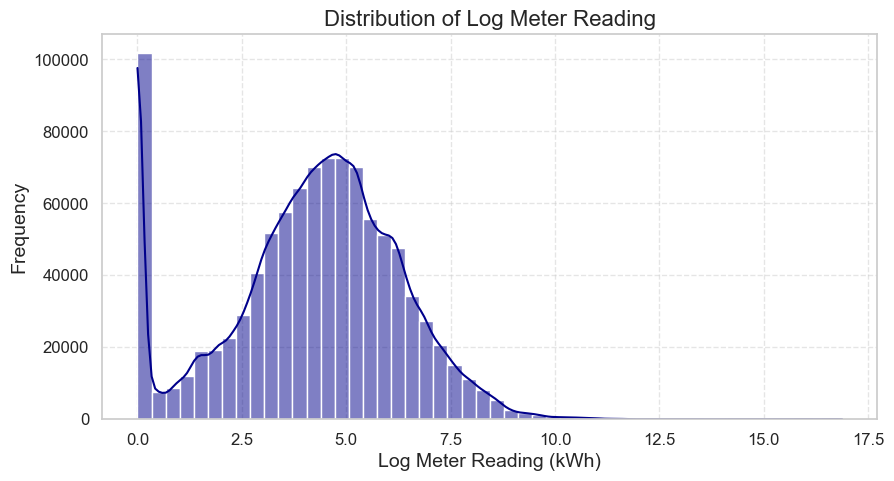

In [71]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(10, 5))
sns.histplot(train_sample['log_meter_reading'], bins=50 ,kde=True, color='darkblue')
plt.title('Distribution of Log Meter Reading')
plt.xlabel('Log Meter Reading (kWh)')
plt.ylabel('Frequency')

plt.show()

2. Scatter Plot - relationship bw log_meter_reading (energy use) and air_temperature

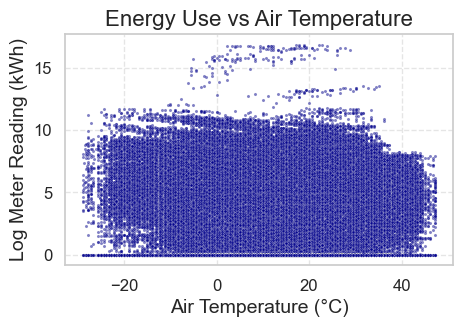

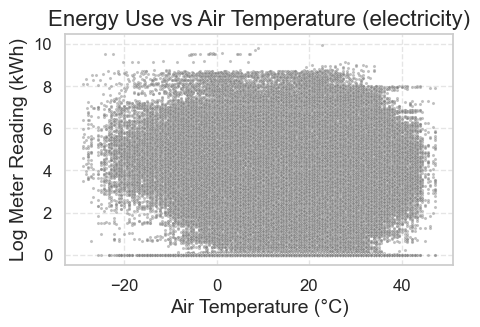

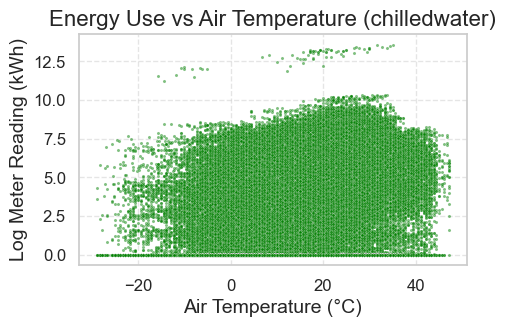

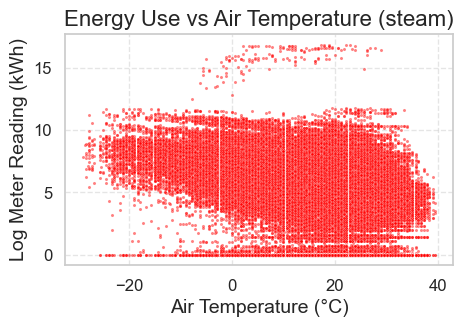

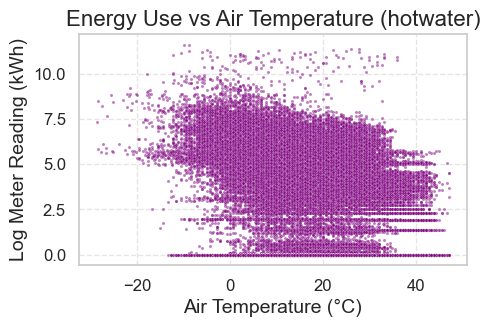

In [82]:
plt.figure(figsize=(5, 3))
sns.scatterplot(x='air_temperature', y=train_sample['log_meter_reading'], s=5, color='darkblue', alpha=0.5, data=train_sample)
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Log Meter Reading (kWh)')
plt.title('Energy Use vs Air Temperature')
plt.show()

# for different meter types
colors = {0: 'gray', 1: 'green', 2: 'red', 3: 'purple'}
meter_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

for meter_id, meter_name in meter_types.items():
    plt.figure(figsize=(5, 3))
    sns.scatterplot(x='air_temperature', y='log_meter_reading', s=5, color=colors[meter_id], alpha=0.5, data=train_sample[train_sample['meter'] == meter_id])
    plt.xlabel('Air Temperature (°C)')
    plt.ylabel('Log Meter Reading (kWh)')
    plt.title(f'Energy Use vs Air Temperature ({meter_name})')
    plt.show()

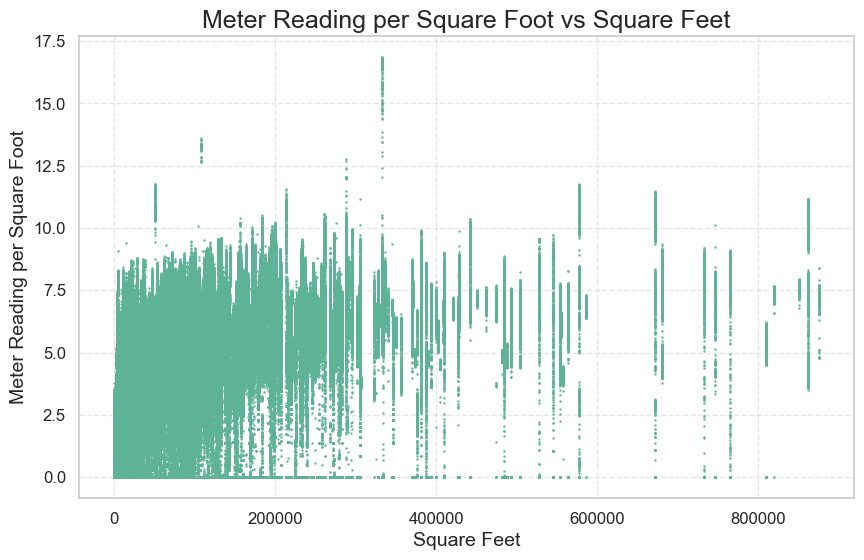

In [124]:
plt.figure(figsize=(10, 6))
plt.scatter(train_sample['square_feet'], train_sample['log_meter_reading'], s=0.5)
plt.xlabel('Square Feet')
plt.ylabel('Meter Reading per Square Foot')
plt.title('Meter Reading per Square Foot vs Square Feet')
plt.show()

Understanding zeros:

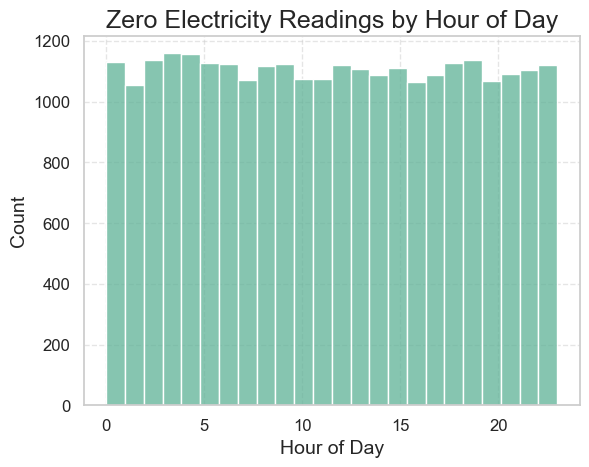

In [125]:
zero_electricity = train_sample[(train_sample['meter'] == 0) & (train_sample['meter_reading'] == 0)]
sns.histplot(zero_electricity['hour'], bins=24)
plt.title('Zero Electricity Readings by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.show()

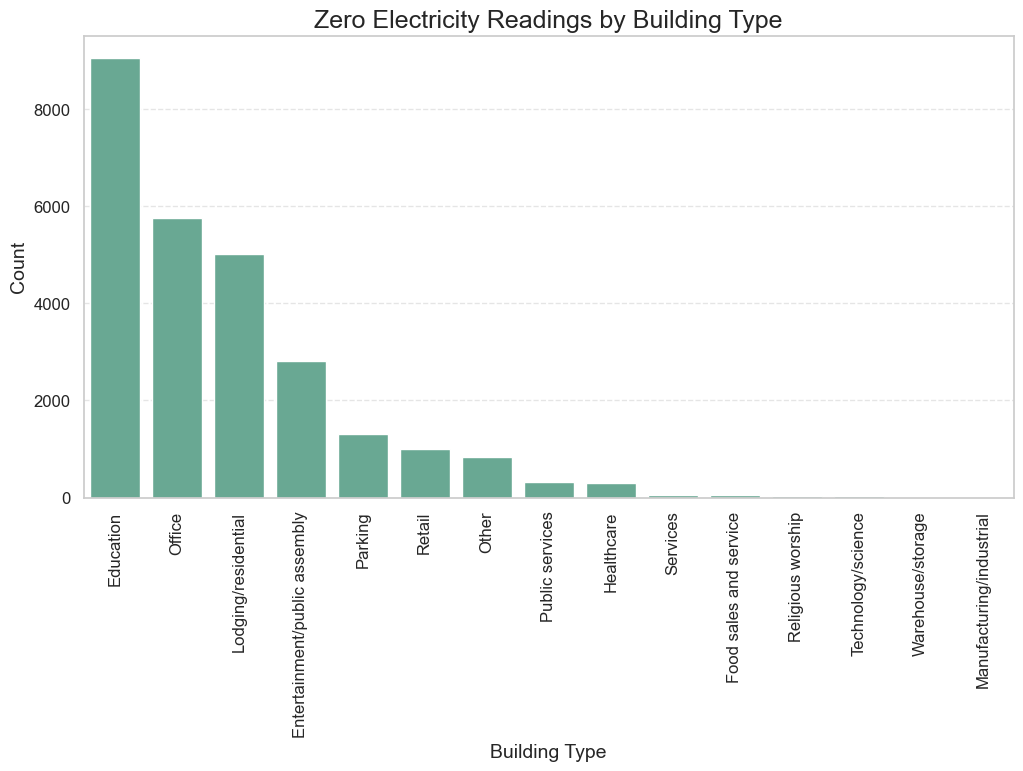

In [126]:
plt.figure(figsize=(12, 6))
sns.countplot(data=zero_electricity, x='primary_use', order=zero_electricity['primary_use'].value_counts().index)
plt.title('Zero Electricity Readings by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

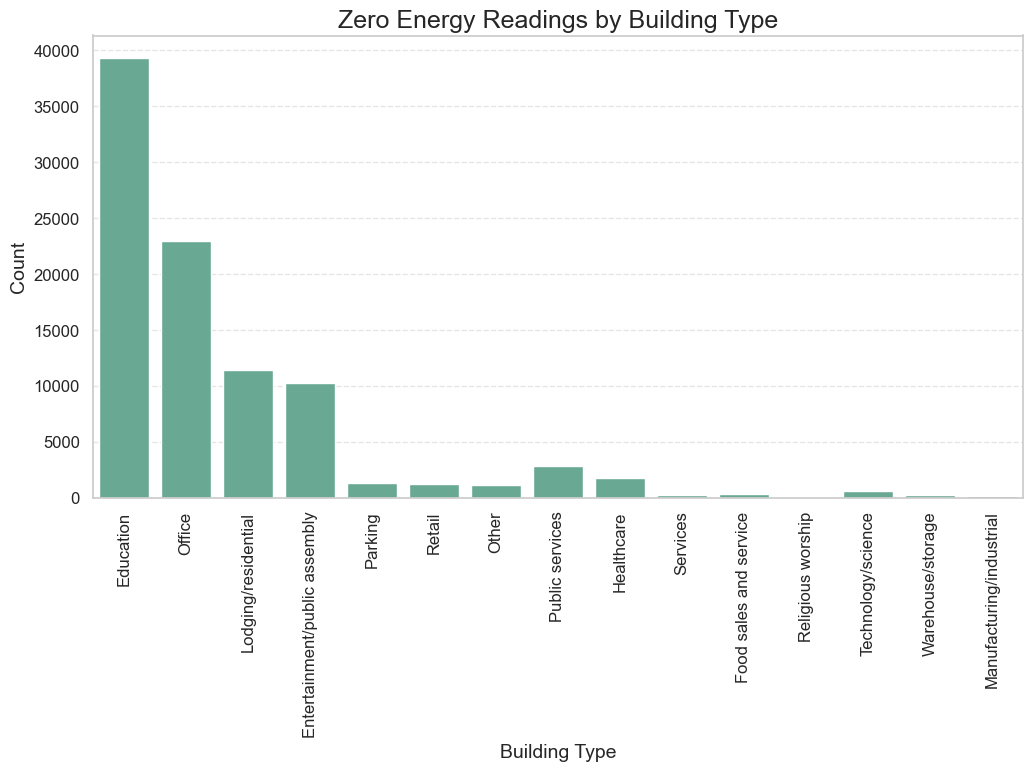

In [127]:
zero_energy = train_sample[(train_sample['meter_reading'] == 0)]

plt.figure(figsize=(12, 6))
sns.countplot(data=zero_energy, x='primary_use', order=zero_electricity['primary_use'].value_counts().index)
plt.title('Zero Energy Readings by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [96]:
train_sample['zero_flag'] = (train_sample['meter'] == 0) & (train_sample['meter_reading'] == 0)
train_sample.groupby('building_id')['zero_flag'].mean().sort_values(ascending=False).head(10)

building_id
53      0.876712
1221    0.822384
857     0.701944
853     0.662763
1113    0.582960
815     0.558685
817     0.531553
1446    0.497436
45      0.479358
64      0.441379
Name: zero_flag, dtype: float64

3. Correlation Heatmap - relationship between air_temperature and log_meter_reading.

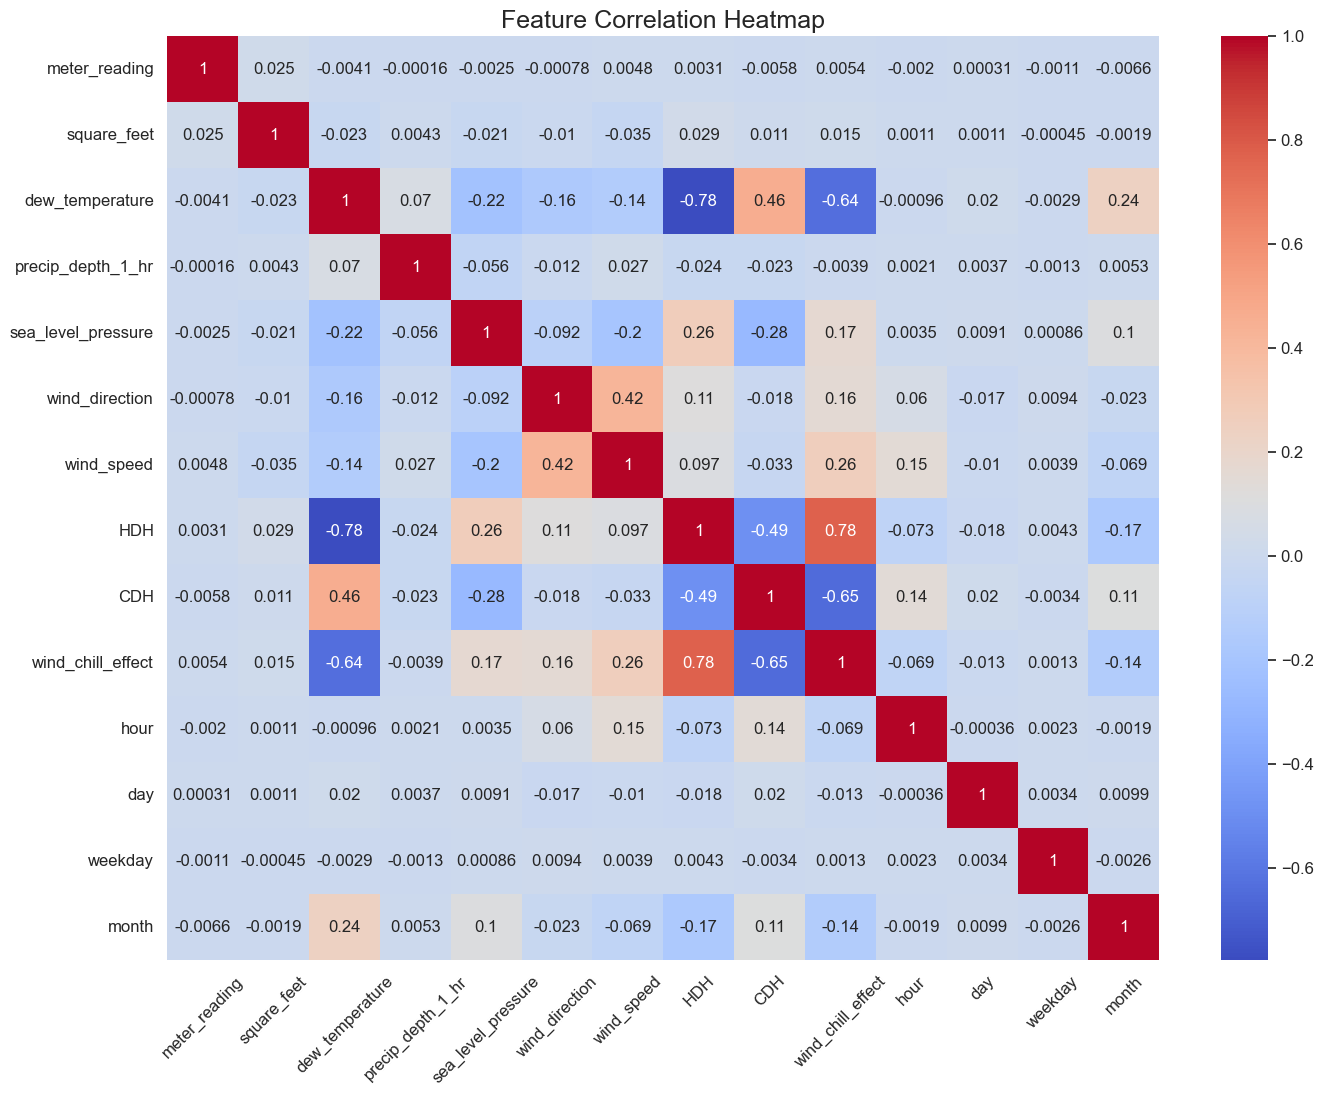

In [128]:
plt.figure(figsize=(16, 12))
corr = train_sample[['meter_reading', 'square_feet', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
                     'wind_direction', 'wind_speed', 'HDH', 'CDH', 'wind_chill_effect', 'hour', 'day', 'weekday', 'month']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

## Linear Regression Model

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

features = ['square_feet', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
            'wind_direction', 'wind_speed', 'HDH', 'CDH', 'wind_chill_effect', 'hour', 'weekday']
target = 'log_meter_reading'

X = train_sample[features]
y = train_sample[target]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Is it a right move???

In [132]:
print(X_train.isnull().sum())

X_train = X_train.dropna()
y_train = y_train[X_train.index]

X_test = X_test.dropna()
y_test = y_test[X_test.index]

print(X_train.isnull().sum())
print(X_train.info())

square_feet           0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
HDH                   0
CDH                   0
wind_chill_effect     0
hour                  0
weekday               0
dtype: int64
square_feet           0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
HDH                   0
CDH                   0
wind_chill_effect     0
hour                  0
weekday               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 802723 entries, 775871 to 442860
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   square_feet         802723 non-null  int64  
 1   dew_temperature     802723 non-null  float64
 2   precip_depth_1_hr   802723 non-null  float64
 3   sea_level_pressure  802723 non-null  float64
 4   wind_direction      802723 non

In [133]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

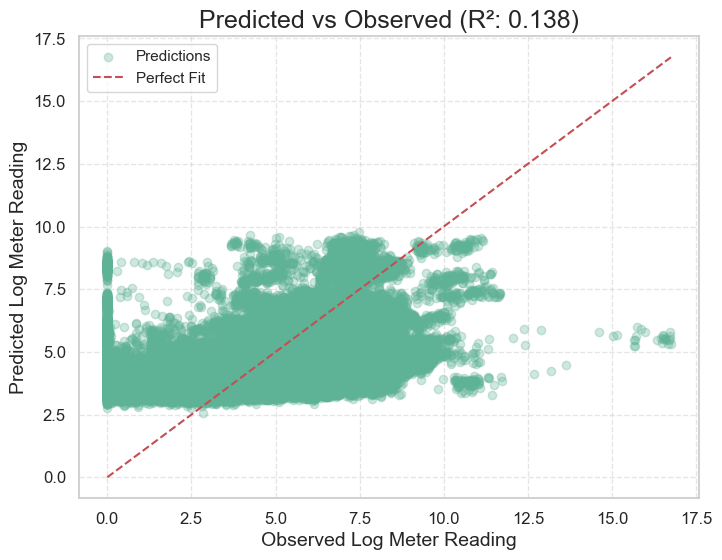

R² Score: 0.138


In [134]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.title(f'Predicted vs Observed (R²: {r2:.3f})')
plt.xlabel('Observed Log Meter Reading')
plt.ylabel('Predicted Log Meter Reading')
plt.legend()
plt.show()

print(f"R² Score: {r2:.3f}")

### Accuracy VS Complexity

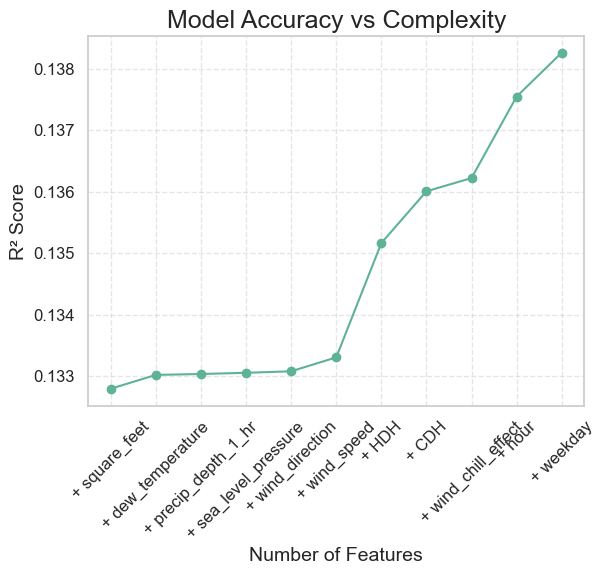

In [135]:
features = ['square_feet', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
            'wind_direction', 'wind_speed', 'HDH', 'CDH', 'wind_chill_effect', 'hour', 'weekday']
accuracy_scores = []

for i in range(1, len(features) + 1):
    selected_features = features[:i]
    X = train_sample[selected_features]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = X_train.dropna()
    y_train = y_train[X_train.index]

    X_test = X_test.dropna()
    y_test = y_test[X_test.index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    # eval accuracy
    y_pred = model.predict(X_test)
    accuracy_scores.append(r2_score(y_test, y_pred))

plt.plot(range(1, len(features) + 1), accuracy_scores, marker='o')
plt.title('Model Accuracy vs Complexity')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.xticks(ticks=range(1, len(features) + 1), labels=[f'+ {feature}' for feature in features], rotation=45)
plt.show()


## 2. Exploratory Data Analysis (EDA)

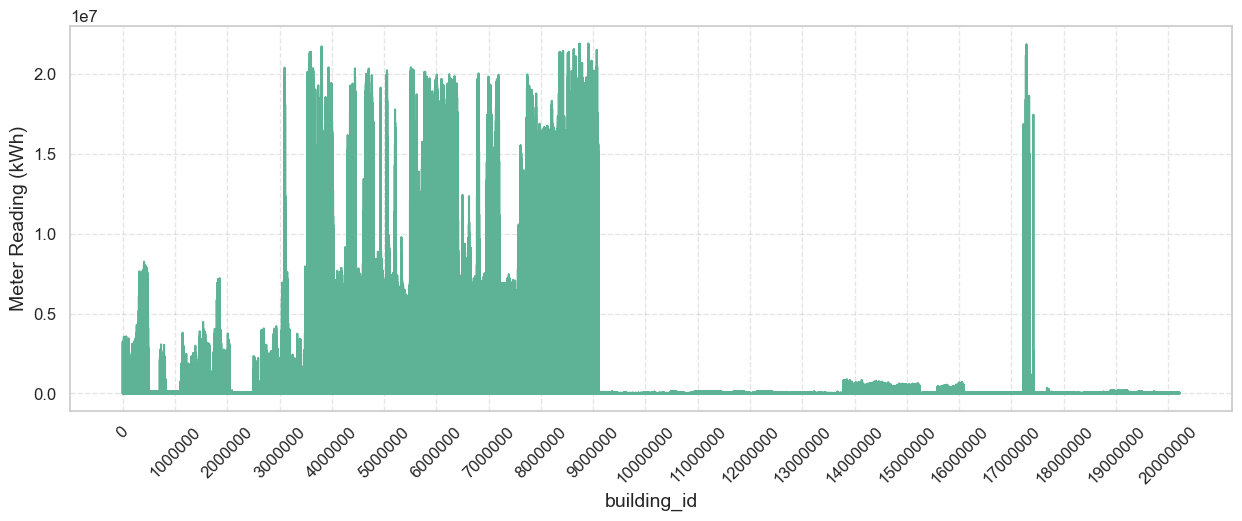

In [136]:
plt.figure(figsize = (15,5))
train_merged['meter_reading'].plot()
plt.xlabel('building_id')
plt.ylabel('meter_reading (kWh)')
plt.xticks(ticks=range(0, len(train_merged['building_id']), 1_000_000), labels=range(0, len(train_merged['building_id']), 1_000_000), rotation=45)
plt.ylabel('Meter Reading (kWh)')
plt.show()


In [28]:
sns.scatterplot(x='air_temperature', y='meter_reading', data=train_merged, s=7)
plt.title('Meter Reading vs Air Temperature')
plt.show()

NameError: name 'train_merged' is not defined